# Car Plate Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/georgia-tech-db/eva-application-template/blob/main/car_plate_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/georgia-tech-db/eva-application-template/blob/main/car_plate_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/georgia-tech-db/eva-application-template/blob/main/car_plate_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

In [168]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [169]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File '00-start-eva-server.ipynb' already there; not retrieving.

nohup eva_server > eva.log 2>&1 &

Note: you may need to restart the kernel to use updated packages.


### Getting the Video Files

### Load the surveillance videos for analysis

In [170]:
cursor.execute('DROP TABLE IF EXISTS MyVideos;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "1.mp4" INTO MyVideos;')
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                       0
0  Table Successfully dropped: MyVideos
@query_time: 0.03623203805182129
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.32878233201336116


### Visualize Video

In [171]:
from ipywidgets import Video
Video.from_file("1.mp4", embed=True)

Video(value=b'\x00\x00\x00\x1cftypmp42\x00\x00\x00\x01isommp41mp42\x00\x00\x00\x01mdat\x00\x00\x00\x00...')

### Create Custom UDF for Car Plate Detection

In [172]:
cursor.execute("DROP UDF IF EXISTS CarPlateDetector;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS CarPlateDetector
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (results NDARRAY FLOAT32(ANYDIM, ANYDIM))
      TYPE  Classification
      IMPL  'car_plate_detector.py';
      """) 
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                            0
0  UDF CarPlateDetector successfully dropped
@query_time: 0.018401494016870856
@status: ResponseStatus.SUCCESS
@batch: 
                                                           0
0  UDF CarPlateDetector successfully added to the database.
@query_time: 1.3053191340295598


### Run Car Plate Detector on Video

In [173]:
cursor.execute("""SELECT id, CarPlateDetector(data)
                  FROM MyVideos 
                  WHERE id < 1""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
    myvideos.id  \
0            0   

                                                                              carplatedetector.results  
0  [[0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], [0 0 0 ... 0 0 0], ...  
@query_time: 5.893736046040431


### Visualize Model Output on Video

In [174]:
import cv2
import numpy as np
def image_resize(image, width=None, height=None, inter=cv2.INTER_CUBIC):
    # https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation=inter)

    return resized

In [175]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    # https://stackoverflow.com/questions/4993082/how-to-sharpen-an-image-in-opencv
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [176]:
def show_images(images, cols=1, prefix='Image ', titles=None):
    # https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = [f'{prefix} ({i})' for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [177]:
def remove_noise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    # Find contours and remove small noise
    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 200:
            cv2.drawContours(opening, [c], -1, 0, -1)

    # Invert and apply slight Gaussian blur
    result = 255 - opening
    #result = cv2.GaussianBlur(result, (3,3), 0)
    return result

In [178]:
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))


    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read()
    car_plates = []

    while ret:
        df = detections
        df = df[['carplatedetector.results']][df.index == frame_id]
        if df.size:
            dfList = df.values.tolist()
            mask = np.array(dfList[0][0])
            mask = mask.astype(np.uint8)
            #plt.imshow(mask)
            #frame = cv2.cvtColor(np.array(frame, copy=True), cv2.COLOR_RGB2BGR)
            contours, hierarchy = cv2.findContours(
                mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            plates = []

            for j, c in enumerate(contours):
                x,y,w,h = cv2.boundingRect(c)
                plate = frame[y:y+h, x:x+w]
                fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
                fps = 25
                dim = plate.shape[:2]
                video = cv2.VideoWriter("frame" + str(frame_id)+ "_plate" + str(j) + ".mp4", fourcc, fps, (dim[1], dim[0]))
                for _ in range(50): video.write(plate)
                video.release()
                plates.append(plate)
                if frame_id % 5 == 0:
                    plt.imshow(plate)
                    plt.show()
            # show_images(plates,  prefix='License plate')
            car_plates.append(plates)
        frame_id+=1
        ret, frame = vcap.read()
    return car_plates

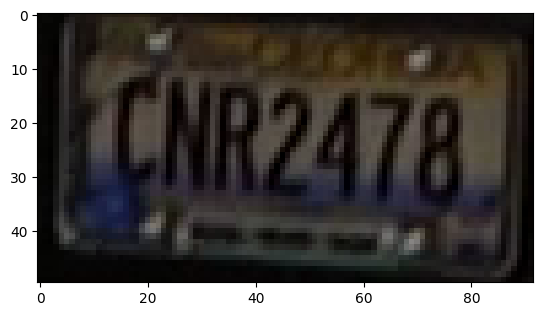

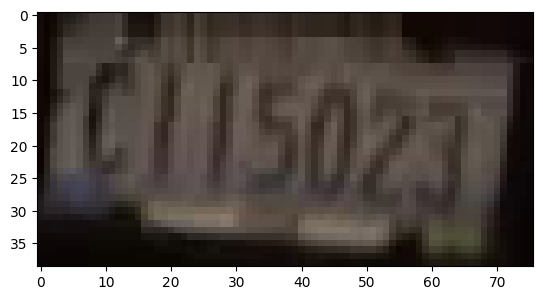

In [179]:
from ipywidgets import Video, Image
input_path = "1.mp4"
dataframe = response.batch.frames
car_plates = annotate_video(dataframe, input_path)

In [180]:
from PIL import Image
def plates2videos(car_plates):
    for i, plates in enumerate(car_plates):
        for j, plate in enumerate(plates):
            fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
            fps = 25
            dim = plate.shape[:2]
            video = cv2.VideoWriter("frame" + str(i)+ "_plate" + str(j) + ".mp4", fourcc, fps, (dim[1], dim[0]))
            plate = cv2.cvtColor(plate, cv2.COLOR_RGB2BGR)
            for _ in range(50): video.write(plate)
            video.release()

In [181]:
plates2videos(car_plates)

In [182]:
cursor.execute("DROP UDF OCRExtractor;")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                        0
0  UDF OCRExtractor successfully dropped
@query_time: 0.02304618409834802


In [183]:
cursor.execute("""CREATE UDF IF NOT EXISTS OCRExtractor
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
              scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'ocr_extractor.py';
      """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                                       0
0  UDF OCRExtractor successfully added to the database.
@query_time: 2.4929564719786867


In [184]:
#for i, plates in enumerate(car_plates):
#    for j, plate in enumerate(plates):
i=0
j=0
file_name = "frame" + str(i)+ "_plate" + str(j) + ".mp4"
print(file_name)
cursor.execute('DROP TABLE MyVideos')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "' + file_name + '" INTO MyVideos;')
response = cursor.fetch_all()
print(response)
cursor.execute("""SELECT id, OCRExtractor(data)
                FROM MyVideos
                WHERE id < 1""")
response = cursor.fetch_all()
print(response)

frame0_plate0.mp4
@status: ResponseStatus.SUCCESS
@batch: 
                                       0
0  Table Successfully dropped: MyVideos
@query_time: 0.026179561973549426
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.05453889595810324
@status: ResponseStatus.SUCCESS
@batch: 
    myvideos.id ocrextractor.labels                     ocrextractor.bboxes  \
0            0         [[c017726]]  [[[0, 7], [84, 7], [84, 46], [0, 46]]]   

     ocrextractor.scores  
0  [0.15990134416995833]  
@query_time: 4.82309387892019


In [185]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video_ocr(detections, input_video_path, output_video_path):
    color1=(0, 255, 150)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    print(detections)
    plate_id = 0

    while ret:
        df = detections
        df = df[['ocrextractor.bboxes', 'ocrextractor.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[plate_id][0], dfLst[plate_id][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1[0]), int(x1[1]), int(x2[0]), int(x2[1])
                print(x1)
                print(y1)
                # object bbox
                frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                print(label)
                frame = cv2.putText(frame, label, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 1, color2, thickness, cv2.LINE_AA) 
            video.write(frame)

            # Show every  frame
            plt.imshow(frame)
            plt.show()
                
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

In [186]:
from ipywidgets import Video, Image
input_path = 'frame0_plate0.mp4'
output_path = 'frame0_plate0.mp4'

   myvideos.id ocrextractor.labels                     ocrextractor.bboxes  \
0            0         [[c017726]]  [[[0, 7], [84, 7], [84, 46], [0, 46]]]   

     ocrextractor.scores  
0  [0.15990134416995833]  
0
7
[c017726]


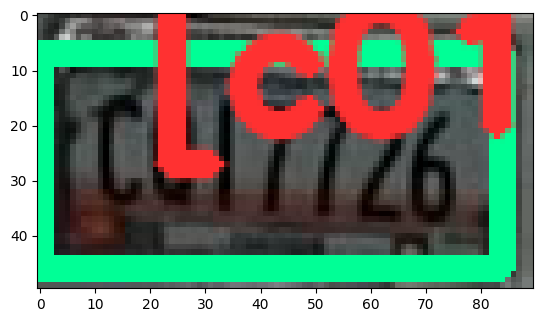

In [187]:
dataframe = response.batch.frames
annotate_video_ocr(dataframe, input_path, output_path)
#Video.from_file(output_path)